# Test 3D hydrodynamics model
---

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from torch.optim          import Adam
from tqdm                 import tqdm
from astropy              import units, constants

from p3droslo.model       import TensorModel
from p3droslo.lines       import Line
from p3droslo.loss        import Loss, diff_loss
from p3droslo.haar        import Haar
from p3droslo.plot        import plot_cube_2D

In [2]:
line = Line('CO', 2)

You have selected line:
    CO(J=3-2)
Please check the properties that were inferred:
    Frequency         3.457959899e+11  Hz
    Einstein A coeff  2.497000000e-06  1/s
    Molar mass        28.0101          g/mol


/home/frederikd/.local/lib/python3.9/site-packages/astroquery/lamda/core.py:145: UserWarning: The first time a LAMDA function is called, it must assemble a list of valid molecules and URLs.  This list will be cached so future operations will be faster.
  warnings.warn("The first time a LAMDA function is called, it must "


## Model
---

In [3]:
import plons

setupData = plons.LoadSetup('/STER/frederikd/', "wind")
dumpData  = plons.LoadFullDump('/STER/frederikd/wind_00600', setupData)

position = dumpData["position"]*1e-2     # position vectors        [cm   -> m]
velocity = dumpData["velocity"]*1e3      # velocity vectors        [km/s -> m/s]
rho      = dumpData["rho"]               # density                 [g/cm^3]
tmp      = dumpData["Tgas"]              # temperature             [K]
tmp[tmp<2.725] = 2.725                   # Cut-off temperatures below 2.725 K

v_x, v_y, v_z = velocity[:,0], velocity[:,1], velocity[:,2]

# Convert rho (total density) to abundances
nH2 = rho * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

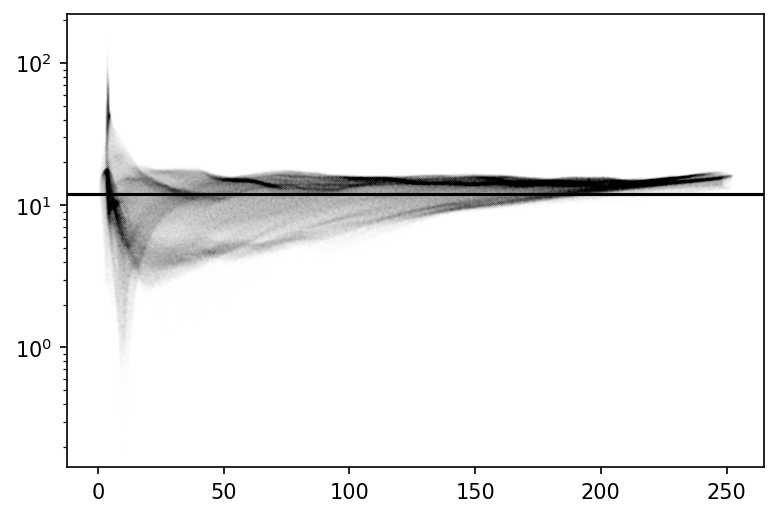

In [4]:
rs  = np.linalg.norm(position, axis=1)
v_r = np.sqrt(v_x**2 + v_y**2 + v_z**2)

plt.figure(dpi=150)
# plt.scatter(rs, v_r/1.0e+3, s=0.1)
plt.scatter(rs / (1.0 * units.au).si.value, v_r/1.0e+3, s=9.0e-7, c='k')

vmax = v_r.mean()

plt.yscale('log')

plt.axhline(vmax / 1.0e+3, c='k')

In [5]:
vmax

11938.315426148189

In [6]:
# Define turbulence at 150 m/s
trb = 150.0

# Map point data to a regular grid
haar = Haar(position, q=8)

imin = 2**(haar.q-3)
imax = 3*imin

nCO_dat = haar.map_data(nCO, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
tmp_dat = haar.map_data(tmp, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_x_dat = haar.map_data(v_x, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_y_dat = haar.map_data(v_y, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]
v_z_dat = haar.map_data(v_z, interpolate=True)[-1][imin:imax,imin:imax,imin:imax]

assert tmp_dat.shape == nCO_dat.shape
assert tmp_dat.shape == v_z_dat.shape

model_test = TensorModel(shape=nCO_dat.shape, sizes=haar.xyz_L)
model_test['log_CO'          ] = np.log(nCO_dat).astype(np.float64)
model_test['log_temperature' ] = np.log(tmp_dat).astype(np.float64)
model_test['velocity_x'      ] =        v_x_dat .astype(np.float64) / vmax
model_test['velocity_y'      ] =        v_y_dat .astype(np.float64) / vmax
model_test['velocity_z'      ] =        v_z_dat .astype(np.float64) / vmax
model_test['log_v_turbulence'] = np.log(trb)*np.ones(model_test.shape, dtype=np.float64)

In [7]:
model_test.save('models/model_3D.h5')

Text(0.5, 0, 'Radius [au]')

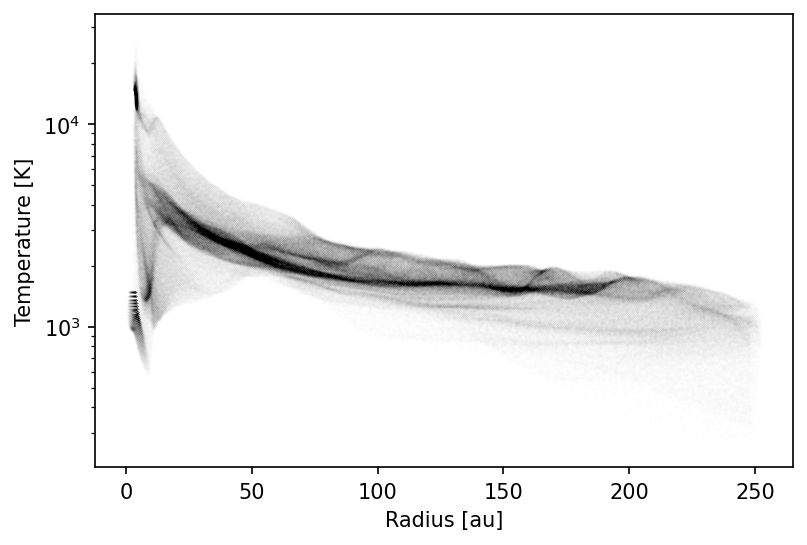

In [8]:
plt.figure(dpi=150)
plt.scatter(rs / (1.0 * units.au).si.value, tmp, s=1.0e-6, c='k')
# plt.ylim((0,20000))
plt.yscale('log')

plt.ylabel('Temperature [K]')
plt.xlabel('Radius [au]')

In [9]:
tx = v_x/v_r - position[:,0]/rs
ty = v_y/v_r - position[:,1]/rs
tz = v_z/v_r - position[:,2]/rs

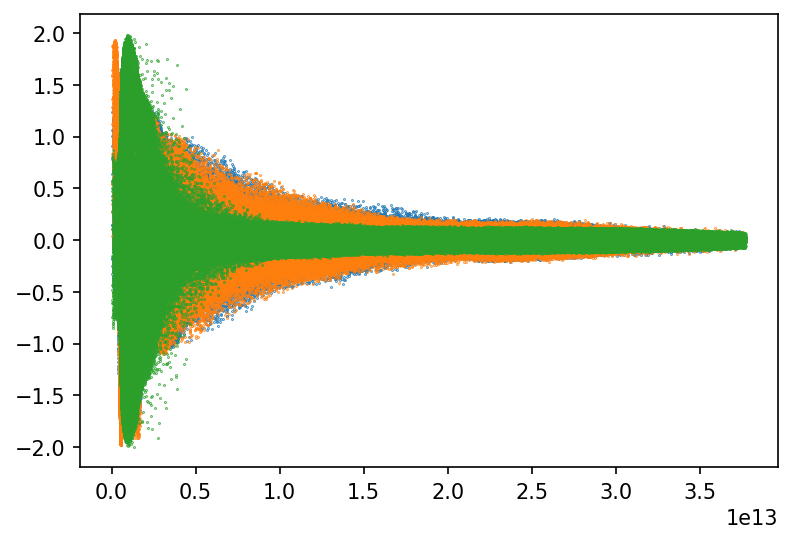

In [10]:
plt.figure(dpi=150)
plt.scatter(rs, tx, s=0.1)
plt.scatter(rs, ty, s=0.1)
plt.scatter(rs, tz, s=0.1)

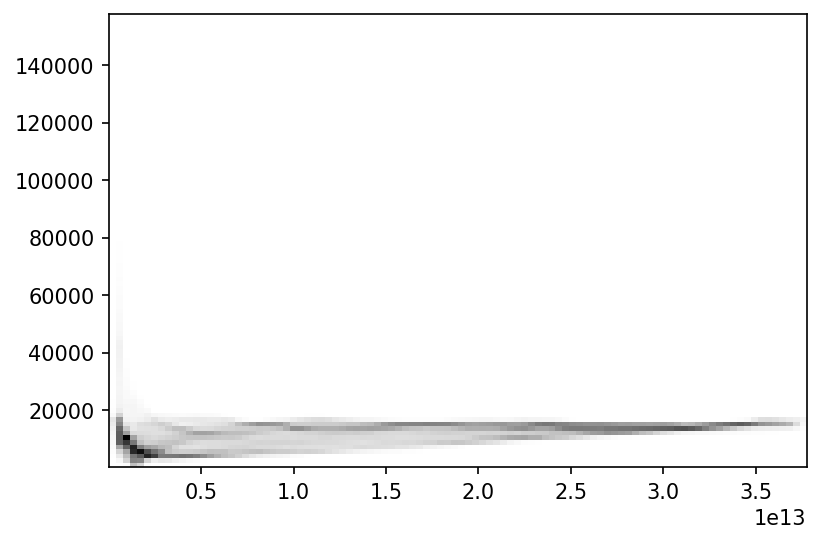

In [11]:
plt.figure(dpi=150)
plt.hist2d(rs, v_r, bins=(100,100), cmap='Greys')
plt.show()

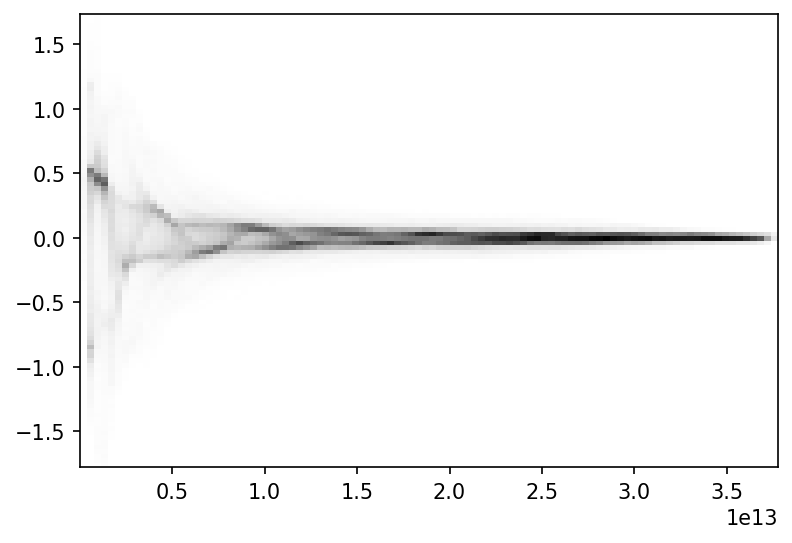

In [12]:
plt.figure(dpi=150)
plt.hist2d(rs, tx, bins=(100,100), cmap='Greys')
plt.show()

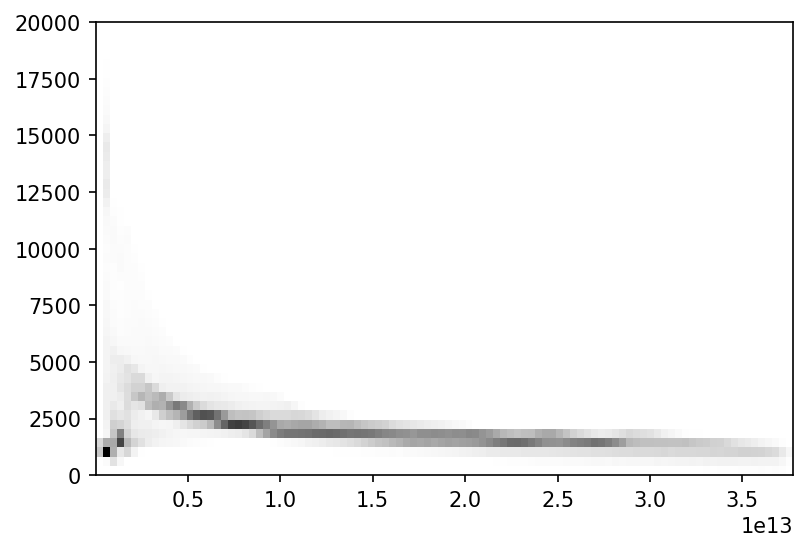

In [13]:
plt.figure(dpi=150)
plt.hist2d(rs, tmp, bins=(100,np.linspace(0, 20000)), cmap='Greys')
plt.ylim((0,20000))
plt.show()

In [14]:
plot_cube_2D(np.log(nCO_dat))

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [15]:
vdiff = 350   # velocity increment size [m/s]
nfreq = 100   # number of frequencies
dd    = vdiff / constants.c.si.value * nfreq
fmin  = line.frequency - line.frequency*dd
fmax  = line.frequency + line.frequency*dd

frequencies = torch.linspace(fmin, fmax, nfreq)
velocities = (frequencies / line.frequency - 1.0) * constants.c.si.value

In [16]:
def forward(model):
    
    img = line.LTE_image_along_last_axis(
        density      = torch.exp(model['log_CO'          ]),
        temperature  = torch.exp(model['log_temperature' ]),
        v_turbulence = torch.exp(model['log_v_turbulence']),
        velocity_los =    vmax * model['velocity_z'      ] ,
        frequencies  = frequencies,
        dx           = model.dx(0)
    )
    
    return 1.0e+12 * img

In [17]:
obs = forward(model_test)
obs = np.abs(obs) + 1.0e-20

In [18]:
plot_cube_2D(np.log(obs))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

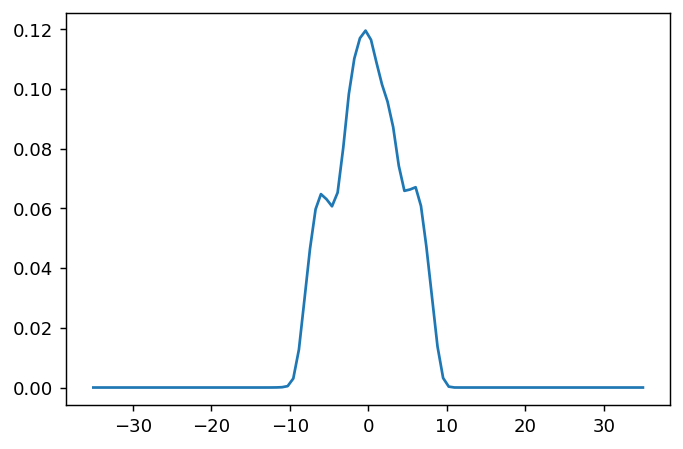

In [19]:
plt.figure(dpi=130)
plt.plot(velocities/1.0e+3, obs.sum(dim=(0,1)))

# Fit
---

In [56]:
model = TensorModel.load('models/model_3D.h5')

In [57]:
r_x, r_y, r_z = model.get_radial_direction(origin='centre')

model['log_CO'          ] = np.log(1.0e+7) * np.ones(model.shape)
# model['log_temperature' ] = np.log(5.0e+2) * np.ones(model.shape)
# model['log_v_turbulence'] = np.log(1.5e+2) * np.ones(model.shape)
# model['velocity_x'      ] = 1.0e+0 * r_x
# model['velocity_y'      ] = 1.0e+0 * r_y
# model['velocity_z'      ] = 1.0e+0 * r_z

# Explicitly set all model variables free (i.e. all will be fitted) except the turbulence
model.free_all()
model.fix('log_temperature' )
model.fix('log_v_turbulence')
model.fix('velocity_x')
model.fix('velocity_y')
model.fix('velocity_z')

# loss = Loss(['rep', 'reg', 'cnt', 'tmp'])
loss = Loss(['rep', 'reg'])

In [58]:
img = forward(model)

In [59]:
img.abs().mean()

tensor(5.2748e-06, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [62]:
plot_cube_2D(np.log(img.data+1.0e-12))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [63]:
plot_cube_2D(img.data)

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [32]:
r = model.get_radius(origin='centre')

In [35]:
r.max() / r.min()

63.0

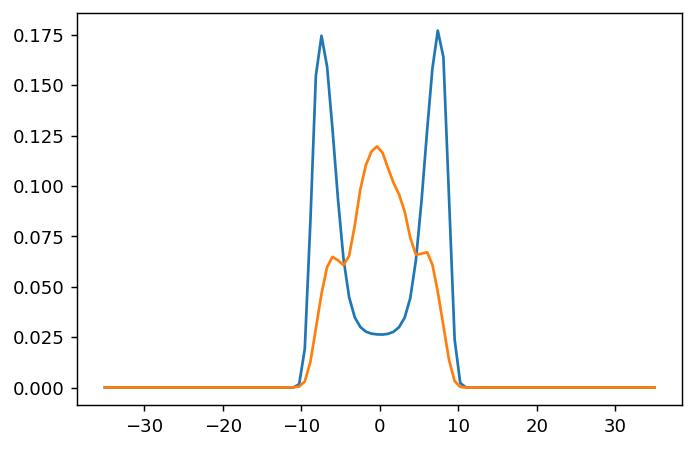

In [65]:
plt.figure(dpi=130)
plt.plot(velocities/1.0e+3, img.data.sum(dim=(0,1)))
plt.plot(velocities/1.0e+3, obs.data.sum(dim=(0,1)))

In [66]:
def fit(loss, model, obs, N_epochs=100, lr=1.0e-1, w_rep=1.0, w_reg=1.0, w_cnt=1.0, w_tmp=1.0):

    optimizer = Adam(model.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward(model)
 
        # Compute the reproduction loss
        loss['rep'] = w_rep * torch.nn.functional.mse_loss(img, obs)
        # Compute the regularisation loss
        loss['reg'] = w_reg * model.apply(diff_loss)
        # Compute the hydrodynamic loss
        # loss['cnt'] = w_cnt * steady_state_cont_loss(spherical, torch.from_numpy(r))    
        # loss['tmp'] = w_tmp * steady_state_heat_loss(spherical, torch.from_numpy(r))    

        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

    return img

  0%|          | 0/3 [00:00<?, ?it/s]/home/frederikd/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 3/3 [00:15<00:00,  5.25s/it]


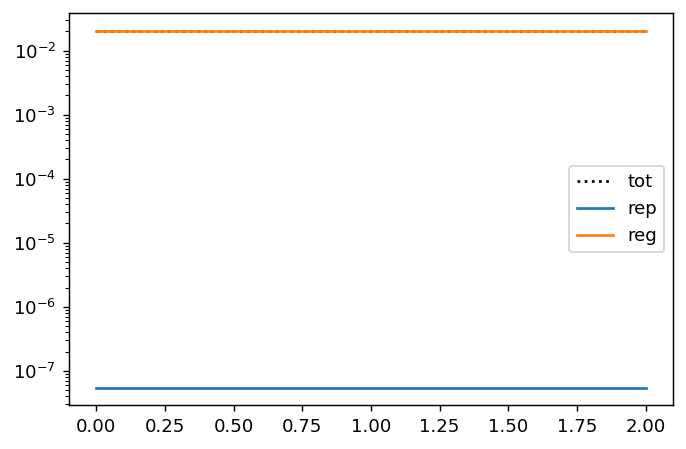

In [67]:
img = fit(loss, model, obs, N_epochs=3, lr=1.0e-1)
loss.plot()

In [1]:
model.info()

NameError: name 'model' is not defined

In [69]:
loss.renormalise_all()
loss.reset()

100%|██████████| 3/3 [00:16<00:00,  5.57s/it]


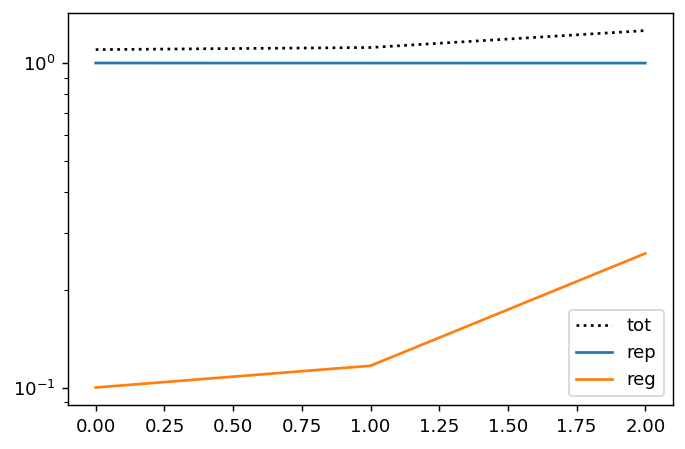

In [70]:
img = fit(loss, model, obs, N_epochs=3, lr=1.0e-1, w_reg=1.0e-1)
loss.plot()

In [29]:
loss.weight['rep'] *= 1.0e+2
loss.weight['reg'] *= 1.0e+0

1.2585488557815552

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [44:40<00:00, 10.72s/it]


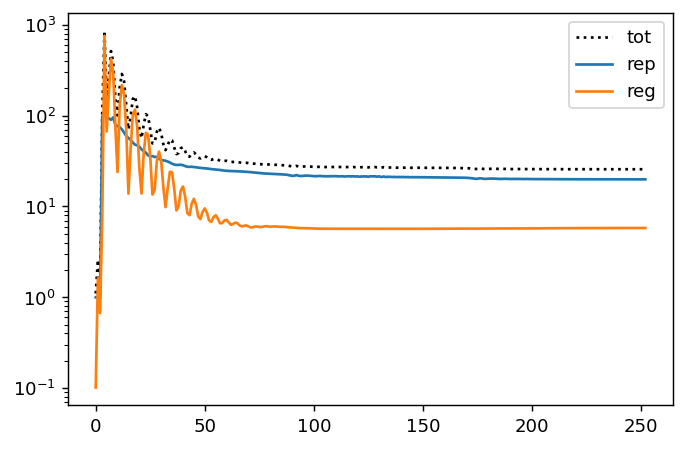

In [30]:
img = fit(loss, model, obs, N_epochs=250, lr=5.0e-1)
loss.plot()

In [31]:
loss.weight['rep'] *= 1.0e+2
loss.weight['reg'] *= 1.0e+0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [16:54<00:00, 10.14s/it]


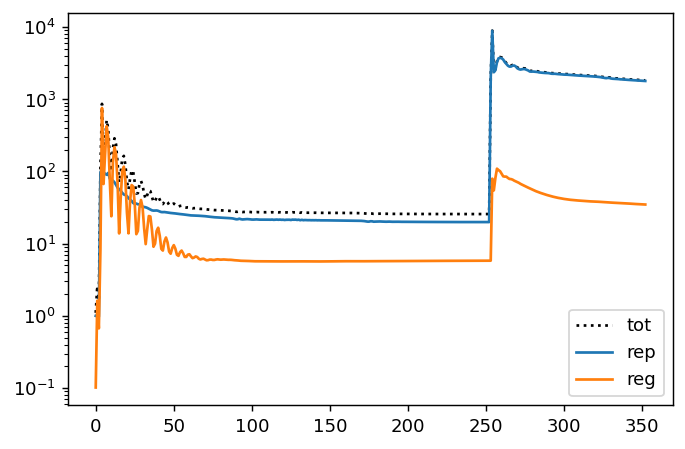

In [32]:
img = fit(loss, model, obs, N_epochs=100, lr=5.0e-1)
loss.plot()

In [33]:
loss.weight['rep'] *= 1.0e+2
loss.weight['reg'] *= 1.0e+0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [35:44<00:00,  8.58s/it]


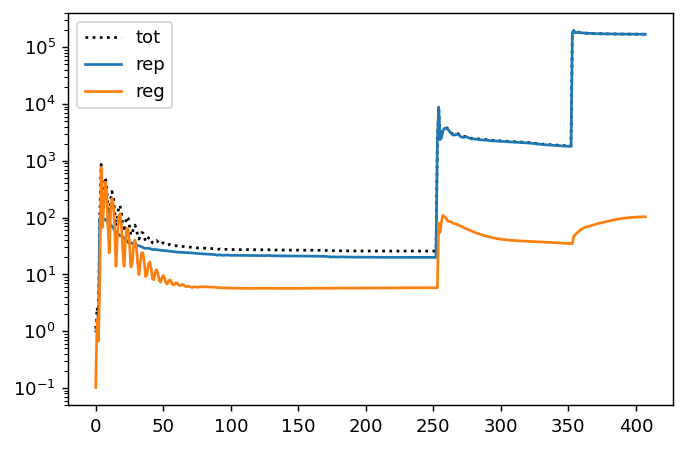

In [34]:
img = fit(loss, model, obs, N_epochs=250, lr=1.0e-1)
loss.plot()

In [35]:
model.save('Phantom_model_0.h5')

In [20]:
model = TensorModel.load('models/model_3D_CO_all.h5')

In [21]:
plot_cube_2D(model['log_CO'])

interactive(children=(IntSlider(value=31, description='z', max=63), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [22]:
img = forward(model)

In [23]:
plot_cube_2D(torch.log(img+1.0e-10))

interactive(children=(IntSlider(value=49, description='z', max=99), Output()), _dom_classes=('widget-interact'…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [24]:
from ipywidgets import interact

def plot(i,j):
    plt.figure(dpi=150)
    plt.plot   (line.freq_to_velo(frequencies          * units.Hz), obs[i,j,:].data)
    plt.plot   (line.freq_to_velo(frequencies          * units.Hz), img[i,j,:].data, marker='x')
interact(plot, i=(0, img.shape[0]-1), j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=31, description='i', max=63), IntSlider(value=31, description='j', max=6…

<function __main__.plot(i, j)>

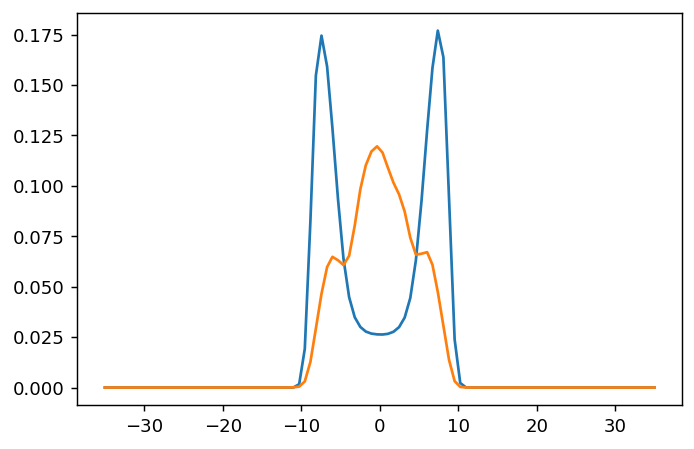

In [25]:
plt.figure(dpi=130)
plt.plot(velocities/1.0e+3, img.data.sum(dim=(0,1)))
plt.plot(velocities/1.0e+3, obs.data.sum(dim=(0,1)))

In [36]:
# plot_cube_2D(model['log_CO'])

In [37]:
# def velocity_cube_2D(coords, vx, vy, vz):
#     """
#     Plot a slice along the third axis through a 3D cube.
#     """
#     v = torch.sqrt(vx**2 + vy**2 + vz**2)

#     vmin = v.min().item()
#     vmax = v.max().item()

#     def plot(z):
#         plt.figure(dpi=150)
#         # plt.imshow(v[:,:,z].T.data, vmin=vmin, vmax=vmax, origin='lower')
#         plt.quiver(
#             coords[0,:,:,z],
#             coords[1,:,:,z],
#             (vx/v)[:,:,z].data,
#             (vy/v)[:,:,z].data,
#             # color = 'white',
#             pivot='mid'
#         )
#     return interact(plot, z=(0,v.shape[2]-1))

# velocity_cube_2D(
#     coords = model.get_coords(),
#     vx     = model['velocity_x'],
#     vy     = model['velocity_y'],
#     vz     = model['velocity_z']
# )

In [38]:
# def fourier_loss_3D(arr):
    
#     fft = torch.abs(torch.fft.fftn(arr))
    
#     wgt = np.indices(fft.shape)
#     wgt = (wgt.T - 0.5*np.array(fft.shape)).T
#     wgt = np.linalg.norm(wgt, axis=0)
    
#     wgt = torch.from_numpy(wgt)

#     loss = torch.mean((torch.fft.fftshift(fft)*wgt)**2)
    
#     return loss

In [39]:
# gamma  = 1.2
# mu     = 2.381
# factor = 2.0 * constants.R.si.value / (mu * (gamma - 1.0))


# def lagrangian(model):
#     """
#     Forward model: image the given TensorModel at the given frequencies.
#     """
#     nCO    = torch.exp(model['log_CO'])         
#     tmp    = torch.exp(model['log_temperature'])
#     vel    =  3.0e+3 * model['velocity_z']
#     v_turb = torch.exp(model['log_v_turbulence'])

#     return nCO * (vel**2 - factor * tmp)

In [40]:
# gamma = 1.2
# mu    = 2.381 * constants.u.si.value

# def steady_state_hydrodynamic_loss(model, f_x=0.0, f_y=0.0, f_z=0.0, heating_m_cooling=0.0):
#     """
#     Loss assuming steady state hydrodynamics, i.e. vanishing time derivatives.
#     """

#     o_1 = model.shape * (r_grav_1 - haar.xyz_min) / haar.xyz_L
#     o_2 = model.shape * (r_grav_2 - haar.xyz_min) / haar.xyz_L
    
#     r_1 = model.get_coords(origin=o_1)
#     r_2 = model.get_coords(origin=o_2)

#     d_1 = torch.from_numpy(r_1 / np.linalg.norm(r_1, axis=0)**3)
#     d_2 = torch.from_numpy(r_2 / np.linalg.norm(r_2, axis=0)**3)
    
#     log_rho = model['log_CO']
#     log_tmp = model['log_temperature'] 
#     log_M_1 = model['log_M_1']
#     log_M_2 = model['log_M_2']

#     rho = torch.exp(log_rho)         
#     tmp = torch.exp(log_tmp)
#     M_1 = torch.exp(log_M_1)
#     M_2 = torch.exp(log_M_2)
    
#     v_x = 3.0e+3 * model['velocity_x']
#     v_y = 3.0e+3 * model['velocity_y']
#     v_z = 3.0e+3 * model['velocity_z']

#     kBT_o_mu = (constants.k_B.si.value / mu) * tmp

#     # Energy    
#     eng = 0.5 * (v_x**2 + v_y**2 + v_z**2) + (gamma / (gamma - 1.0)) * kBT_o_mu

#     # log rho + log T
#     log_rho_p_log_tmp = log_rho + log_tmp
    
#     f_x = -constants.G.si.value * (M_1 * d_1[0] + M_2 * d_2[0])
#     f_y = -constants.G.si.value * (M_1 * d_1[1] + M_2 * d_2[1])
#     f_x = -constants.G.si.value * (M_1 * d_1[2] + M_2 * d_2[2])

#     # Continuity equation (steady state): div(ρ v) = 0
#     loss_cont = model.diff_x(rho * v_x) + model.diff_y(rho * v_y) + model.diff_z(rho * v_z)

#     # Momentum equation (steady state): v . grad(v) + grad(P) / rho = f
#     loss_momx = v_x * model.diff_x(v_x) + v_y * model.diff_y(v_x) + v_z * model.diff_z(v_x) + kBT_o_mu * model.diff_x(log_rho_p_log_tmp) - f_x
#     loss_momy = v_x * model.diff_x(v_y) + v_y * model.diff_y(v_y) + v_z * model.diff_z(v_y) + kBT_o_mu * model.diff_y(log_rho_p_log_tmp) - f_y
#     loss_momz = v_x * model.diff_x(v_z) + v_y * model.diff_y(v_z) + v_z * model.diff_z(v_z) + kBT_o_mu * model.diff_z(log_rho_p_log_tmp) - f_z

#     # Energy equation (steady state): div(u v) = 0
#     loss_engy = rho * (model.diff_x(eng) * v_x + model.diff_y(eng) * v_y + model.diff_z(eng) * v_z) - heating_m_cooling

#     # Compute the mean squared losses
#     losses = torch.stack([
#         ((loss_cont/     rho )**2).mean(),
#         ((loss_momx/     v_x )**2).mean(),
#         ((loss_momy/     v_y )**2).mean(),
#         ((loss_momz/     v_z )**2).mean(),
#         ((loss_engy/(rho*eng))**2).mean()
#     ])

#     # Return losses
#     return losses

In [41]:
# loss_cont, loss_momx, loss_momy, loss_momz, loss_engy = steady_state_hydrodynamic_loss(model_test)

In [42]:
# steady_state_hydrodynamic_loss(model_test)